In [ ]:
# Load Libraries and Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

# Set display options for better viewing
pd.set_option('display.max_columns', 50)
#sns.set(style='whitegrid')

In [ ]:
# Load both datasets (Card metadata and Card images)

df_cards = pd.read_csv('./Data/pokemon-tcg-data-master 1999-2023.csv')        # Main TCG data
df_imgs = pd.read_csv('./Data/pokemon-cards.csv')                             # Card image info (Priyam Choksi Kaggle dataset)


In [ ]:
# 3. Check for data issues (nulls in key fields)
key_fields = ['id', 'name', 'set', 'series', 'types', 'supertype', 'subtypes', 'hp', 'rarity', 'attacks', 'abilities']

print("Null value count in key fields:")
print(df_cards[key_fields].isnull().sum())

# Check for missing values in image dataset 
print("\nNull value count in image dataset (sample):")
print(df_imgs.isnull().sum())


Null value count in key fields:
id               0
name             0
set              0
series           0
types         2672
supertype        0
subtypes       174
hp            2636
rarity         295
attacks       2663
abilities    13744
dtype: int64

Null value count in image dataset (sample):
id           0
image_url    0
caption      0
name         0
hp           0
set_name     0
dtype: int64


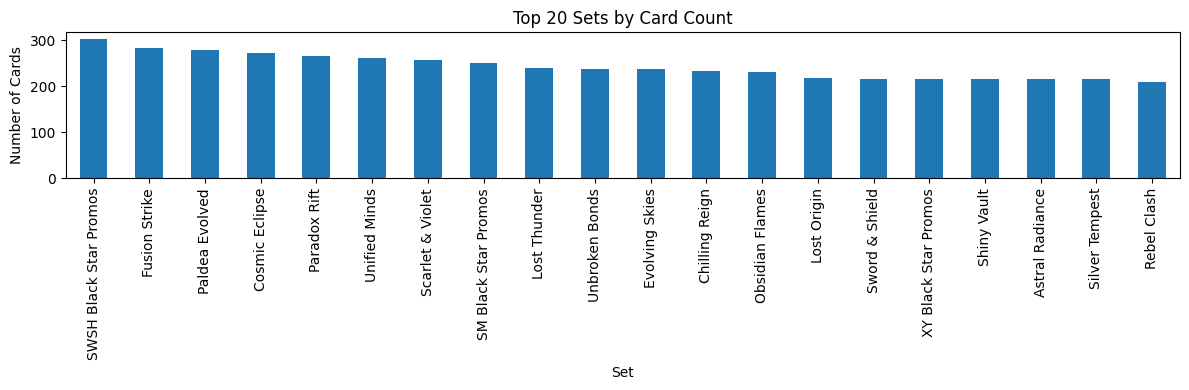

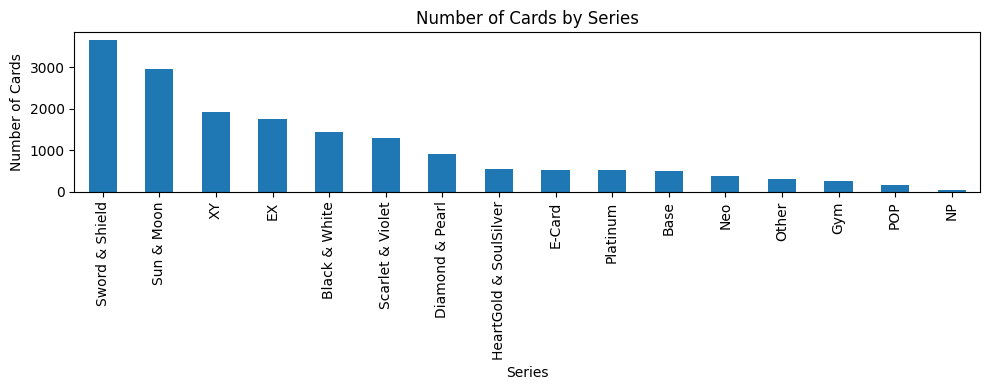

In [ ]:
# EDA

# Number of cards by release/set and by series
plt.figure(figsize=(12, 4))
df_cards['set'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Sets by Card Count')
plt.xlabel('Set')
plt.ylabel('Number of Cards')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
df_cards['series'].value_counts().plot(kind='bar')
plt.title('Number of Cards by Series')
plt.xlabel('Series')
plt.ylabel('Number of Cards')
plt.tight_layout()
plt.show()


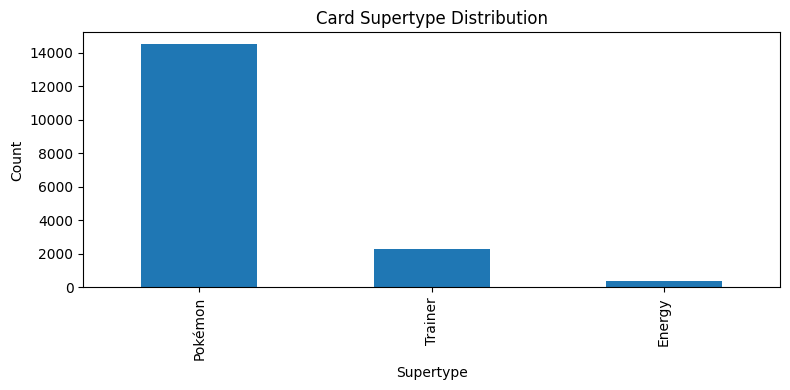

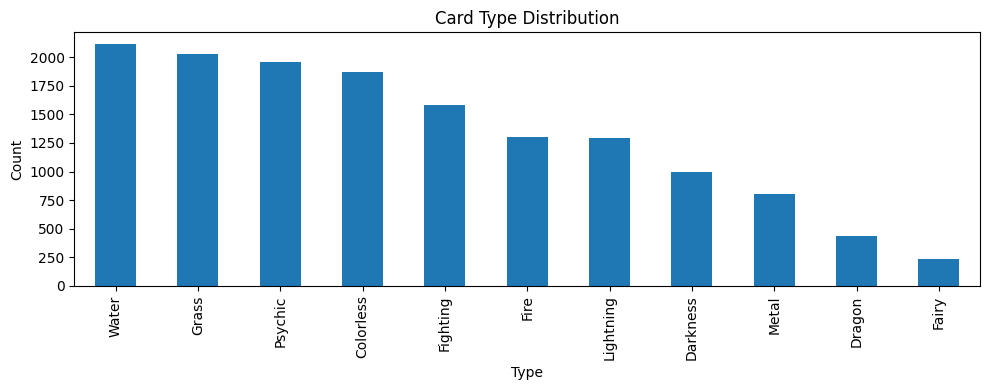

In [ ]:
# Card types and supertypes distribution
plt.figure(figsize=(8,4))
df_cards['supertype'].value_counts().plot(kind='bar')
plt.title('Card Supertype Distribution')
plt.xlabel('Supertype')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

if df_cards['types'].dtype == object:
    df_cards['types_str'] = df_cards['types'].astype(str)
    all_types = df_cards['types_str'].str.strip('[]').str.replace("'", "").str.split(', ')
    type_counts = pd.Series([t for sublist in all_types for t in sublist if t != 'nan']).value_counts()
    plt.figure(figsize=(10,4))
    type_counts.plot(kind='bar')
    plt.title('Card Type Distribution')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


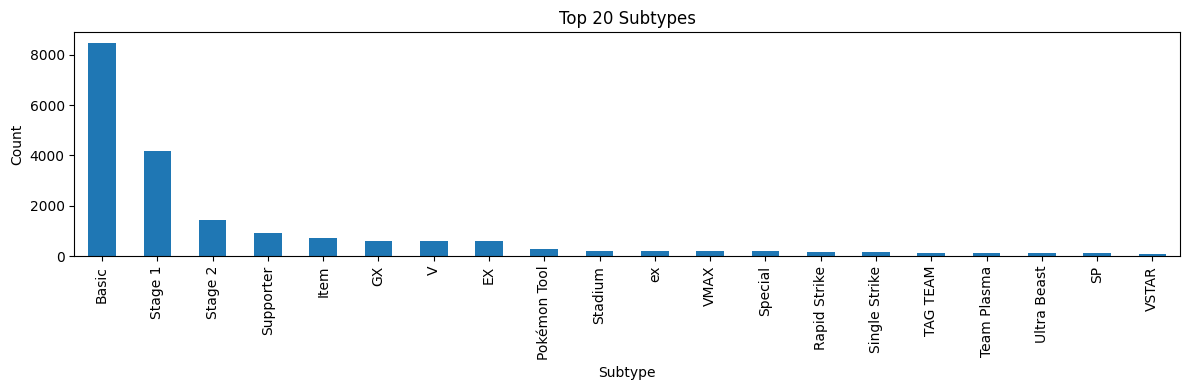

In [ ]:
# Subtype breakdown
if df_cards['subtypes'].dtype == object:
    df_cards['subtypes_str'] = df_cards['subtypes'].astype(str)
    all_subtypes = df_cards['subtypes_str'].str.strip('[]').str.replace("'", "").str.split(', ')
    subtype_counts = pd.Series([t for sublist in all_subtypes for t in sublist if t != 'nan']).value_counts()
    plt.figure(figsize=(12,4))
    subtype_counts.head(20).plot(kind='bar')
    plt.title('Top 20 Subtypes')
    plt.xlabel('Subtype')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


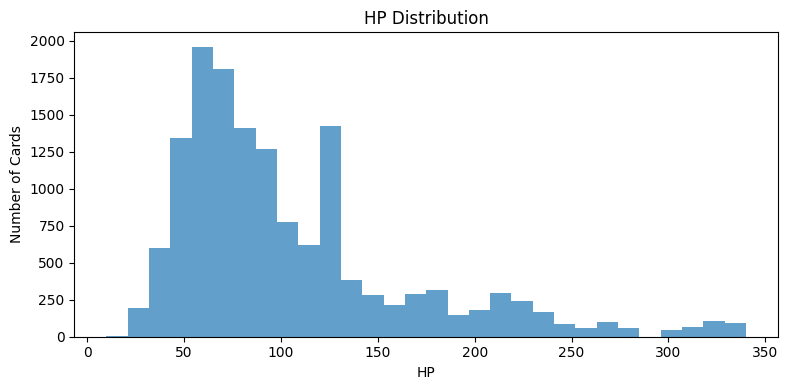

In [8]:
# HP Distribution
plt.figure(figsize=(8,4))
df_cards['hp'] = pd.to_numeric(df_cards['hp'], errors='coerce')
df_cards['hp'].dropna().astype(int).plot(kind='hist', bins=30, alpha=0.7)
plt.title('HP Distribution')
plt.xlabel('HP')
plt.ylabel('Number of Cards')
plt.tight_layout()
plt.show()


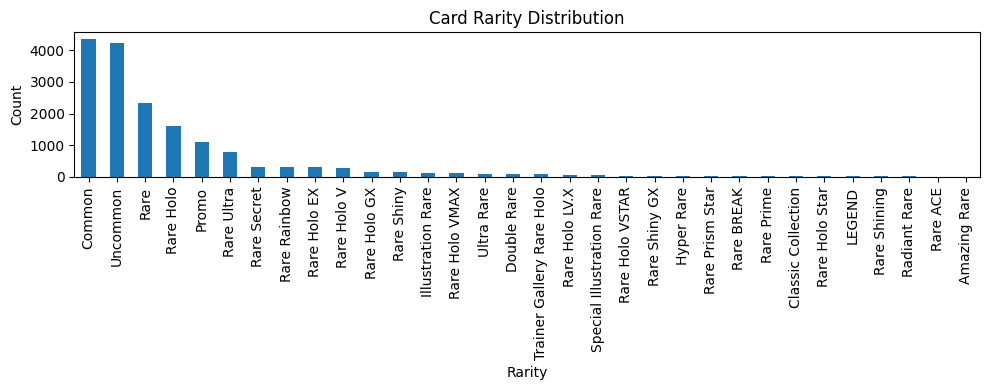

In [9]:
# Rarity analysis
plt.figure(figsize=(10,4))
df_cards['rarity'].value_counts().plot(kind='bar')
plt.title('Card Rarity Distribution')
plt.xlabel('Rarity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Average number of attacks per card: 1.3911600279524807
Average number of abilities per card: 0.20055904961565338


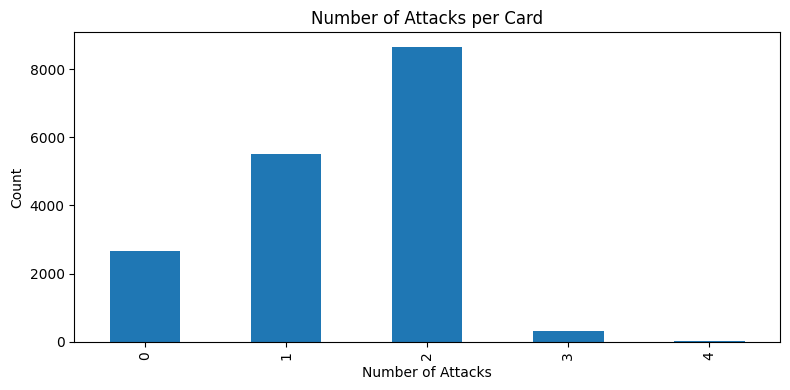

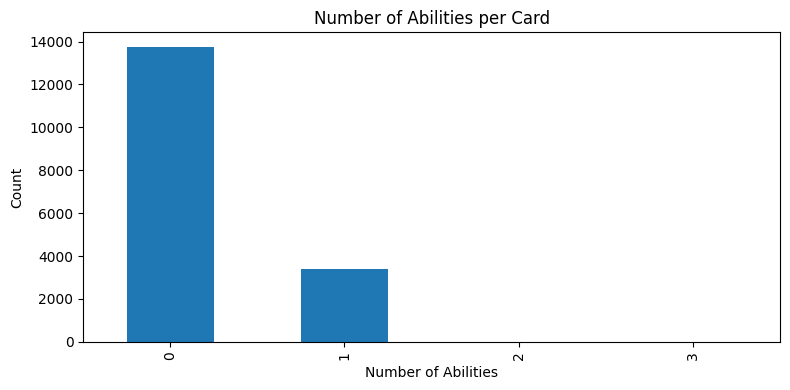

In [ ]:
# Card abilities/attacks: Analyze average number of attacks or abilities per card
df_cards['num_attacks'] = df_cards['attacks'].apply(lambda x: len(eval(x)) if pd.notnull(x) and x.startswith('[') else 0)
df_cards['num_abilities'] = df_cards['abilities'].apply(lambda x: len(eval(x)) if pd.notnull(x) and x.startswith('[') else 0)

print("Average number of attacks per card:", df_cards['num_attacks'].mean())
print("Average number of abilities per card:", df_cards['num_abilities'].mean())

plt.figure(figsize=(8,4))
df_cards['num_attacks'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Attacks per Card')
plt.xlabel('Number of Attacks')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
df_cards['num_abilities'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Abilities per Card')
plt.xlabel('Number of Abilities')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [ ]:
# Normalize names and set columns for reliable merging
def normalize_string(s):
    if pd.isnull(s):
        return ''
    return str(s).lower().strip()

df_cards['name_norm'] = df_cards['name'].apply(normalize_string)
df_cards['set_norm'] = df_cards['set'].apply(normalize_string)
df_cards['key'] = df_cards['name_norm'] + '|' + df_cards['set_norm']

df_imgs['name_norm'] = df_imgs['name'].apply(normalize_string)
df_imgs['set_norm'] = df_imgs['set_name'].apply(normalize_string)
df_imgs['key'] = df_imgs['name_norm'] + '|' + df_imgs['set_norm']


# Filter for Base set cards (first English release, 102 cards)
df_base = df_cards[df_cards['set_norm'] == 'base'].copy()

# Merge Base set cards with image URLs
df_base_img = df_base.merge(df_imgs[['key', 'image_url']], on='key', how='left')

# Check image coverage and list missing cards
n_total = len(df_base_img)
n_with_image = df_base_img['image_url'].notna().sum()
coverage_pct = n_with_image / n_total * 100

print(f"Base set total cards: {n_total}")
print(f"Cards with images: {n_with_image}")
print(f"Image coverage: {coverage_pct:.2f}%")

# List Base set cards missing images (if any)
missing_images = df_base_img[df_base_img['image_url'].isna()]
if missing_images.empty:
    print("All Base set cards have images!")
else:
    print("Base set cards missing images:")
    display(missing_images[['id', 'name', 'set']])


Base set total cards: 102
Cards with images: 69
Image coverage: 67.65%
Base set cards missing images:


,id,name,set
69,base1-70,Clefairy Doll,Base
70,base1-71,Computer Search,Base
71,base1-72,Devolution Spray,Base
72,base1-73,Impostor Professor Oak,Base
73,base1-74,Item Finder,Base
74,base1-75,Lass,Base
75,base1-76,Pokémon Breeder,Base
76,base1-77,Pokémon Trader,Base
77,base1-78,Scoop Up,Base
78,base1-79,Super Energy Removal,Base


In [ ]:
# Merge all cards with image links by id (use 'id' column)
df_merged = df_cards.merge(df_imgs[['id', 'image_url']], on='id', how='left')

# Group by set, count total cards and cards with images
set_stats = (
    df_merged
    .groupby('set')[['name', 'image_url']]
    .agg(
        total_cards=('name', 'count'),
        cards_with_image=('image_url', lambda x: x.notna().sum())
    )
    .reset_index()
)
set_stats['image_coverage_pct'] = 100 * set_stats['cards_with_image'] / set_stats['total_cards']

# Sort by image coverage percentage, descending
set_stats_sorted = set_stats.sort_values('image_coverage_pct', ascending=False)

# Print Top 25 sets with highest image coverage
print("Top 25 Sets with Highest Image Coverage:")
for idx, row in set_stats_sorted.head(25).iterrows():
    print(f"{idx+1:2d}. {row['set']}: {row['cards_with_image']} / {row['total_cards']} cards "
          f"({row['image_coverage_pct']:.2f}% coverage)")


Top 25 Sets with Highest Image Coverage:
79. McDonald's Collection 2011: 12 / 12 cards (100.00% coverage)
81. McDonald's Collection 2014: 12 / 12 cards (100.00% coverage)
88. McDonald's Collection 2022: 15 / 15 cards (100.00% coverage)
87. McDonald's Collection 2021: 25 / 25 cards (100.00% coverage)
103. POP Series 6: 17 / 17 cards (100.00% coverage)
104. POP Series 7: 17 / 17 cards (100.00% coverage)
106. POP Series 9: 17 / 17 cards (100.00% coverage)
86. McDonald's Collection 2019: 12 / 12 cards (100.00% coverage)
85. McDonald's Collection 2018: 12 / 12 cards (100.00% coverage)
114. Pokémon Futsal Collection: 5 / 5 cards (100.00% coverage)
116. Pokémon Rumble: 16 / 16 cards (100.00% coverage)
84. McDonald's Collection 2017: 12 / 12 cards (100.00% coverage)
83. McDonald's Collection 2016: 12 / 12 cards (100.00% coverage)
35. Detective Pikachu: 18 / 18 cards (100.00% coverage)
82. McDonald's Collection 2015: 12 / 12 cards (100.00% coverage)
80. McDonald's Collection 2012: 12 / 12 cards

In [ ]:
# Check total image coverage

total_cards = df_merged['name'].count()
total_with_images = df_merged['image_url'].notna().sum()
total_coverage_pct = 100 * total_with_images / total_cards

print("\n==== TOTAL IMAGE COVERAGE ACROSS ALL SETS ====")
print(f"Total cards: {total_cards}")
print(f"Cards with images: {total_with_images}")
print(f"Overall image coverage: {total_coverage_pct:.2f}%")



==== TOTAL IMAGE COVERAGE ACROSS ALL SETS ====
Total cards: 17172
Cards with images: 13139
Overall image coverage: 76.51%


In [16]:
#Data Imbalance
card_counts = df_merged.groupby('key').size()
print(card_counts.describe())
print("Cards with <3 images:", (card_counts < 3).sum())


count    14417.000000
mean         1.191094
std          0.561094
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         28.000000
dtype: float64
Cards with <3 images: 13919


In [ ]:
#Check URL access
import requests
from PIL import Image
from io import BytesIO

sample_urls = df_merged['image_url'].dropna().sample(5)
for url in sample_urls:
    try:
        img = Image.open(BytesIO(requests.get(url).content))
        img.verify()  
        print(f"OK: {url}")
    except Exception as e:
        print(f"Corrupted or inaccessible: {url} ({e})")


OK: https://images.pokemontcg.io/dp6/10_hires.png
OK: https://images.pokemontcg.io/sm1/3_hires.png
OK: https://images.pokemontcg.io/swsh9/65_hires.png
OK: https://images.pokemontcg.io/sm3/28_hires.png
OK: https://images.pokemontcg.io/sm10/159_hires.png


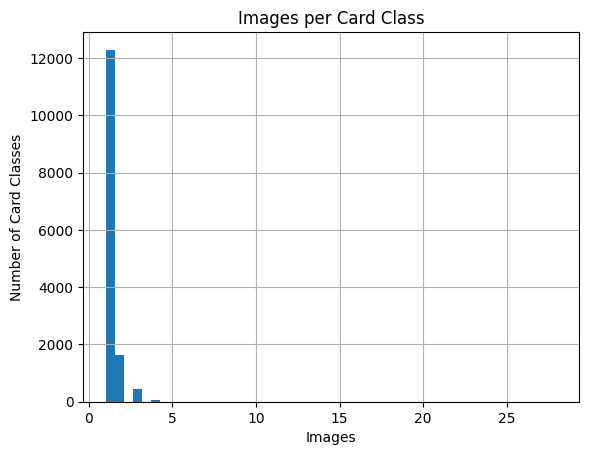

In [18]:
import matplotlib.pyplot as plt

card_counts.hist(bins=50)
plt.title('Images per Card Class')
plt.xlabel('Images')
plt.ylabel('Number of Card Classes')
plt.show()


In [ ]:
#IDs in images but NOT in metadata
img_not_in_meta = set(image_df['id']) - set(meta_df['id'])
print("IDs in images but NOT in metadata:", len(img_not_in_meta))
# Optionally list them
print(img_not_in_meta)


IDs in images but NOT in metadata: 0
set()


In [24]:
# After merge:
merged_df = pd.merge(meta_df, image_df, on="id", how="inner")
print("Rows in merged dataset:", len(merged_df))
print(merged_df.isnull().sum())
# Key columns to check: image_url (or image_path), name, set, set_num, etc.


Rows in merged dataset: 13139
id                            0
set                           0
series                        0
publisher                     0
generation                    0
release_date                  0
artist                        5
name_x                        0
set_num                       0
types                         0
supertype                     0
subtypes                      0
level                     10735
hp_x                          0
evolvesFrom                7573
evolvesTo                  7668
abilities                 10039
attacks                      24
weaknesses                  341
retreatCost                 726
convertedRetreatCost        726
rarity                      235
flavorText                 4476
nationalPokedexNumbers        1
legalities                    0
resistances                9125
rules                     10758
regulationMark            10310
ancientTrait              13080
image_url                     0
caption   

In [25]:
card_counts = merged_df['id'].value_counts()
print(card_counts.describe())
# Or group by set/series for distribution by set
set_counts = merged_df['set'].value_counts()
print(set_counts)


count    13139.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: count, dtype: float64
set
SWSH Black Star Promos       269
SM Black Star Promos         247
Fusion Strike                245
Cosmic Eclipse               229
Unified Minds                216
                            ... 
EX Trainer Kit 2 Minun         7
EX Trainer Kit 2 Plusle        7
EX Trainer Kit Latias          7
EX Trainer Kit Latios          7
Pokémon Futsal Collection      5
Name: count, Length: 147, dtype: int64


In [31]:
# Find duplicate image URLs
dupe_image_urls = df_merged[df_merged.duplicated(subset=['image_url'], keep=False)]

# Group by image_url and pick one group (the first with more than one entry)
sample_dupe = dupe_image_urls.groupby('image_url').filter(lambda x: len(x) > 1)
if not sample_dupe.empty:
    # Display just the first duplicate group
    first_image_url = sample_dupe['image_url'].iloc[0]
    print("Sample duplicate image_url group:")
    display(sample_dupe[sample_dupe['image_url'] == first_image_url])
else:
    print("No duplicate image_url found.")


No duplicate image_url found.
